<a href="https://colab.research.google.com/github/ArturHugo/PLN-2022-1/blob/main/Atividade08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 08 - RNN

In [66]:
# !pip install -U tensorflow
# !pip install -U keras
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import re

In [68]:
import tensorflow_datasets as tfds

ds_train = tfds.load('assin2', split='train', shuffle_files=True)
ds_valid = tfds.load('assin2', split='validation', shuffle_files=False)
ds_test  = tfds.load('assin2', split='test', shuffle_files=False)

In [69]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test  = tfds.as_dataframe(ds_test)

In [70]:
df_train[0:5]

,entailment,hypothesis,id,similarity,text
0,1,b'O pelo de um gato est\xc3\xa1 sendo penteado...,1680,4.8,b'Uma pessoa est\xc3\xa1 escovando um gato'
1,1,b'Um grupo de pessoas est\xc3\xa1 cantando',1456,4.8,b'Gente est\xc3\xa1 cantando'
2,0,b'Uma mulher est\xc3\xa1 cortando br\xc3\xb3co...,4223,4.2,b'Uma mulher est\xc3\xa1 cortando vegetais'
3,0,b'Um menino est\xc3\xa1 batendo em um homem co...,4093,4.1,b'Um menino est\xc3\xa1 batendo em um homem co...
4,1,b'A pessoa est\xc3\xa1 tocando o viol\xc3\xa3o',3017,4.5,b'O homem est\xc3\xa1 tocando o viol\xc3\xa3o'


In [71]:
train_series = [(hypothesis + b' ' + text).decode('utf-8').lower() for (hypothesis, text) in list(zip(df_train['hypothesis'], df_train['text']))]
train_labels = df_train['entailment']

valid_series = [(hypothesis + b' ' + text).decode('utf-8').lower() for (hypothesis, text) in list(zip(df_valid['hypothesis'], df_valid['text']))]
valid_labels = df_valid['entailment']

test_series = [(hypothesis + b' ' + text).decode('utf-8').lower() for (hypothesis, text) in list(zip(df_test['hypothesis'], df_test['text']))]
test_labels = df_test['entailment']

In [72]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

def filter_stopwords(string, stop_list):
  return [word for word in string.split(' ') if word not in stop_list]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
train_series = [filter_stopwords(sample, stopwords) for sample in train_series]
valid_series = [filter_stopwords(sample, stopwords) for sample in valid_series]
test_series  = [filter_stopwords(sample, stopwords) for sample in test_series]


In [74]:
df_train = pd.DataFrame()
df_train['text'] = train_series
df_train['label'] = train_labels

df_valid = pd.DataFrame()
df_valid['text'] = valid_series
df_valid['label'] = valid_labels

df_test = pd.DataFrame()
df_test['text'] = test_series
df_test['label'] = test_labels

In [75]:
# Finding out number of words in the vocabulary to use with tokenizer
unique_words = set()
for sample in df_train['text'].values:
  for word in sample:
    unique_words.add(word)

len(unique_words)

2361

<BarContainer object of 29 artists>

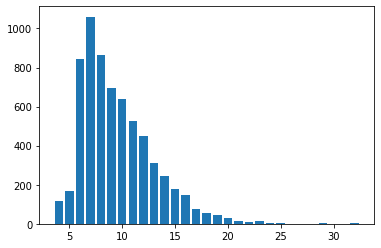

In [76]:
# Finding out apprpriate size for the sequences
sample_lengths = df_train['text'].apply(len).values
sample_length_hist = np.histogram(sample_lengths, bins=29)
length_counts = list(sample_length_hist[0])
lengths = list(sample_length_hist[1][:-1])
plt.bar(lengths, length_counts)

In [77]:
num_words = 2024
max_len = 24
tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(df_train['text'])
df_train['embeds'] = tokenizer.texts_to_sequences(df_train['text'])
train_sequences = pad_sequences(df_train['embeds'],
                                   maxlen=max_len,
                                   padding='post',
                                   truncating='post')
df_valid['embeds'] = tokenizer.texts_to_sequences(df_valid['text'])
valid_sequences = pad_sequences(df_valid['embeds'],
                                   maxlen=max_len,
                                   padding='post',
                                   truncating='post')
df_test['embeds'] = tokenizer.texts_to_sequences(df_test['text'])
test_sequences = pad_sequences(df_test['embeds'],
                                   maxlen=max_len,
                                   padding='post',
                                   truncating='post')
train_sequences

array([[  26,    4, 1342, ...,    0,    0,    0],
       [  50,   10,   47, ...,    0,    0,    0],
       [   2,   17,  547, ...,    0,    0,    0],
       ...,
       [   3,  343,   13, ...,    0,    0,    0],
       [  90,  182,  880, ...,    0,    0,    0],
       [  66,    2,   23, ...,    0,    0,    0]], dtype=int32)

In [78]:
train_sequences[0]

array([  26,    4, 1342,    6,    6,  182,   26,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [79]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [80]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [81]:
X_train = train_sequences
X_valid = valid_sequences
X_test = test_sequences

In [82]:
X_train[0].shape

(24,)

In [83]:
N = train_sequences.shape[0]
print(f'Quantidade de instancias de treinamento {N}')

Quantidade de instancias de treinamento 6500


In [84]:
from keras.models import Sequential
from keras.layers import Input, Dense, SimpleRNN, Embedding, Dropout

def build_model(hp):
  model = Sequential()
  model.add(
    Embedding(
      num_words,
      output_dim=hp.Int("embbeding_output_dim", min_value=32, max_value=128, step=16)
    )
  )
  model.add(
    SimpleRNN(
      units=hp.Int("rnn1_units", min_value=32, max_value=256, step=32),
      return_sequences=True,
      activation='relu'
    )
  )
  model.add(Dropout(0.5))
  model.add(
    SimpleRNN(
      units=hp.Int("rnn2_units", min_value=16, max_value=128, step=16),
      activation='relu'
    )
  )
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
  )
  return model

In [85]:
#!pip install keras-tuner -q

In [86]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="./",
    project_name="rnn_with_keras_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
embbeding_output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
rnn1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
rnn2_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}


In [87]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Trial 3 Complete [00h 01m 08s]
val_accuracy: 0.5009999871253967

Best val_accuracy So Far: 0.6679999828338623
Total elapsed time: 00h 03m 45s


In [89]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [90]:
history = best_model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=50)

Epoch 1/50
204/204 [==============================] - 14s 56ms/step - loss: 0.5653 - accuracy: 0.7074 - val_loss: 0.5649 - val_accuracy: 0.7100
Epoch 2/50
204/204 [==============================] - 11s 55ms/step - loss: 0.5097 - accuracy: 0.7523 - val_loss: 0.5418 - val_accuracy: 0.7300
Epoch 3/50
204/204 [==============================] - 12s 58ms/step - loss: 0.4655 - accuracy: 0.7849 - val_loss: 0.5227 - val_accuracy: 0.7440
Epoch 4/50
204/204 [==============================] - 12s 59ms/step - loss: 0.4428 - accuracy: 0.8022 - val_loss: 0.5259 - val_accuracy: 0.7440
Epoch 5/50
204/204 [==============================] - 11s 56ms/step - loss: 0.4087 - accuracy: 0.8212 - val_loss: 0.5453 - val_accuracy: 0.7600
Epoch 6/50
204/204 [==============================] - 11s 56ms/step - loss: 0.3804 - accuracy: 0.8271 - val_loss: 0.5660 - val_accuracy: 0.7640
Epoch 7/50
204/204 [==============================] - 12s 59ms/step - loss: 0.3446 - accuracy: 0.8409 - val_loss: 0.5045 - val_accuracy:

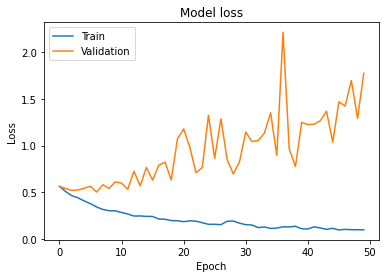

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

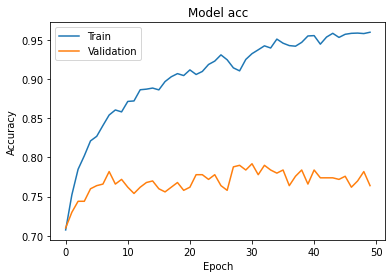

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Avaliação com os Dados de Teste

In [103]:
y = best_model.evaluate(X_test,y_test)

77/77 [==============================] - 1s 7ms/step - loss: 11.5877 - accuracy: 0.5878
